In [1]:
import torch
import torch.nn as nn
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import matplotlib.pyplot as plt

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

def findFiles(path): return glob.glob(path)

print(findFiles('./data/NLP/names/*.txt'))

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]
    
category_lines = {}
all_categories = []
for filename in findFiles('./data/NLP/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
    
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

['./data/NLP/names\\Arabic.txt', './data/NLP/names\\Chinese.txt', './data/NLP/names\\Czech.txt', './data/NLP/names\\Dutch.txt', './data/NLP/names\\English.txt', './data/NLP/names\\French.txt', './data/NLP/names\\German.txt', './data/NLP/names\\Greek.txt', './data/NLP/names\\Irish.txt', './data/NLP/names\\Italian.txt', './data/NLP/names\\Japanese.txt', './data/NLP/names\\Korean.txt', './data/NLP/names\\Polish.txt', './data/NLP/names\\Portuguese.txt', './data/NLP/names\\Russian.txt', './data/NLP/names\\Scottish.txt', './data/NLP/names\\Spanish.txt', './data/NLP/names\\Vietnamese.txt']
# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [5]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item() / input_line_tensor.size(0)

In [7]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%)  %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
        
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s (5000 5%)  2.5771
0m 25s (10000 10%)  2.2263
0m 38s (15000 15%)  2.6073
0m 51s (20000 20%)  2.2161
1m 4s (25000 25%)  1.9774
1m 17s (30000 30%)  2.3035
1m 29s (35000 35%)  2.1577
1m 42s (40000 40%)  2.5861
1m 55s (45000 45%)  2.0653
2m 9s (50000 50%)  0.9761
2m 21s (55000 55%)  2.7207
2m 34s (60000 60%)  3.1461
2m 47s (65000 65%)  2.5279
3m 0s (70000 70%)  3.0160
3m 13s (75000 75%)  0.9628
3m 27s (80000 80%)  2.4741
3m 40s (85000 85%)  2.2861
3m 53s (90000 90%)  3.3509
4m 6s (95000 95%)  2.7148
4m 19s (100000 100%)  2.1030


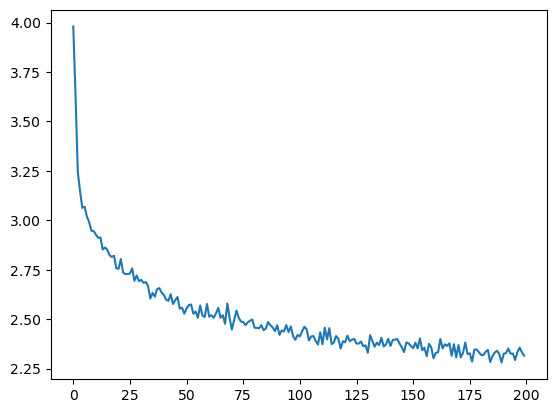

In [9]:
plt.figure()
plt.plot(all_losses)

In [10]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
            
        return output_name
    
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roveko
Uaroveko
Shanovek
Gerre
Erang
Rere
Salla
Pare
Allan
Chang
Han
Iun
